# Informetis Assessment Q3

You are given data of total (aggregated) power consumption, and the TV power consumption of three households. Each household has data for one day.

Task 1: Using TV instantaneous power consumption data, identify the times when the TV is “ON”. Notice that some TVs may have standby modes.

Task 2: Using all the data given, design a classifier to identify times when the TV is “ON”. You may also want to train and test your designed classifier. The trained classifier should not take TV instantaneous power as input.

Please provide a script which attempts task 1 and 2. Please do not provide a script without explanations.

Additional information:

Data format in the attached .csv file: “House” column indicates which house it is, ranging from 1 to 3. “Time” column indicates time stamps. “TV” column indicates TV instantaneous power consumption. “Agg” column indicates total (aggregated) instantaneous power consumption. Sampling rate is 1/60 Hz

# Task 1

## Exploring Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

In [2]:
q3 = pd.read_csv("Q3-data.csv", dtype={'House':np.int32})

In [3]:
q3.head()

,House,Time,TV,Agg
0,1,0.0,11.463,26.205
1,1,1.0,11.702,25.771
2,1,2.0,11.016,24.963
3,1,3.0,11.054,96.582
4,1,4.0,11.123,100.034


**Understanding the Time format**

In [4]:
q3['Time'].describe()

count    4320.000000
mean      719.500000
std       415.740214
min         0.000000
25%       359.750000
50%       719.500000
75%      1079.250000
max      1439.000000
Name: Time, dtype: float64

There are 1440 timesteps, indicating the data is every 1 minute for 24 hours as 24*60 = 1440, the sampling rate of 1/60 Hz also confirms this.

**Apply Time Features for Aggregation**

In the following code, the time is further aggregated on hourly, half hourly and quarter hourly basis, so the Power consumption can be aggregated by max values. This is for easier data processing and visualisation.

In [5]:
q3['hour'] = (q3['Time']//60).astype('int32')
q3['half_hour'] = (q3['Time']//30).astype('int32')
q3['quarter_hour'] = (q3['Time']//15).astype('int32')

q3['hour_float'] = q3['Time']/60

In [6]:
grouped_quarter_hour = q3.groupby(['House', 'quarter_hour'], as_index=False).max().drop(columns=['House', 'Time'])

For the purpose visualisation, we shall assume that every quarter of the hour, either the TV is on or off, after having aggregated the TV power consumption by it's max value

### Visualising Raw Consumption Data

#### TV Power Consumption by Hour

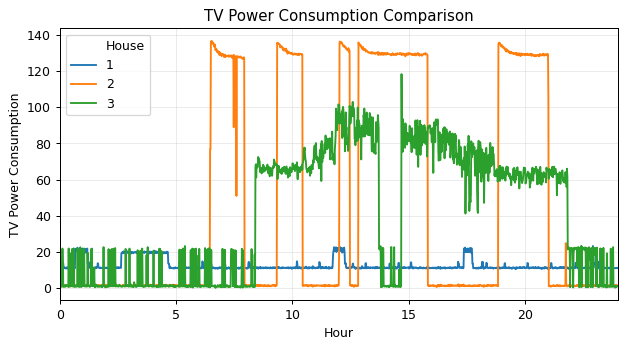

In [7]:
plt.figure(figsize=(8,4), dpi=90)
sns.lineplot('hour_float', 'TV', hue='House', data=q3, legend='full', palette='tab10')
plt.xlabel('Hour')
plt.xlim(0,24)
plt.ylabel('TV Power Consumption')
plt.title('TV Power Consumption Comparison')
plt.grid(alpha=0.25)
plt.show()

#### Total Power Consumption by Hour

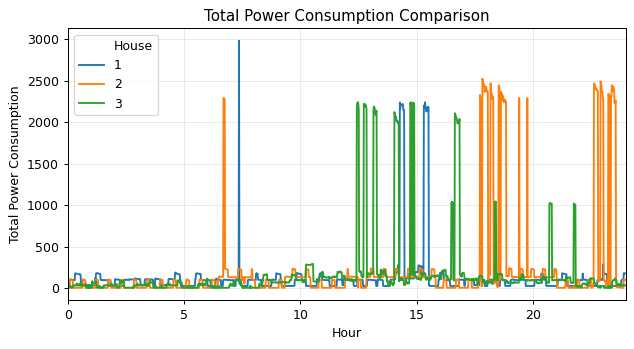

In [8]:
plt.figure(figsize=(8,4), dpi=90)
sns.lineplot('hour_float', 'Agg', hue='House', data=q3, legend='full', palette='tab10')
plt.xlabel('Hour')
plt.xlim(0,24)
plt.ylabel('Total Power Consumption')
plt.title('Total Power Consumption Comparison')
plt.grid(alpha=0.25)
plt.show()

### Discussion

The following can be concluded from the consumptions as illustrated above:

+ Power consumed by the TV in each house is different, for each state of TV: On, Sleep and Off. For instance House 3, seems to have a TV that consumes much less energy than house 2. Whereas House 1 seems to consume negligible energy while on, in comparison with House 2 and 3, though seems to be consuming higher when on standby/off. 
+ Even while the TV is in a particular stage, for instance while it's on, the Power consumed is not constant (or of fixed magnitude). It contineously fluctuates. And the range of this fluctuations also differs from divce to device.
+ The scale of total power consumption can be as much as 20 times higher than the scale of power comsumed by the TV

Hence, it is necessary to take these basic energy consumption patterns for the TV into account for each house separately, by normalising the data separately.

## Transforming Data

Hence, as a simple logic to determine if the TV is on or off, the following steps can be taken:
+ Take the max and min values of the power consumed by TV for each house separately: `TV_min` and `TV_max`
+ Calculate the differce between two (min and max), and use the atleast half of that magnitude as the energy consumed by the TV whilst ON: `half_consumption_power`
+ Create a threshold that determines if the TV is ON: `on_threshold` = `TV_min` + `half_consumption_power`

In [9]:
grouped_tv_data = q3.groupby('House').agg({
    'TV':['min', 'max']
})['TV'].reset_index().rename(columns={
    'min':'TV_min',
    'max':'TV_max'
})

threshold_value = 0.5

grouped_tv_data['max_consumption'] = grouped_tv_data['TV_max'] - grouped_tv_data['TV_min']
grouped_tv_data['half_consumption_power'] = grouped_tv_data['max_consumption']*threshold_value
grouped_tv_data['on_threshold'] = grouped_tv_data['TV_min'] + grouped_tv_data['half_consumption_power']

In [10]:
grouped_tv_data

,House,TV_min,TV_max,max_consumption,half_consumption_power,on_threshold
0,1,10.533,23.303,12.770,6.3850,16.9180
1,2,0.566,136.806,136.240,68.1200,68.6860
2,3,0.125,118.392,118.267,59.1335,59.2585


In [11]:
grouped_quarter_hour = q3.groupby(['House', 'quarter_hour'], as_index=False).max().drop(columns=['Time'])
grouped_merged = pd.merge(grouped_quarter_hour, grouped_tv_data, on='House')
grouped_merged['on'] = (grouped_merged['TV']>grouped_merged['on_threshold']).astype(np.int32)
grouped_merged.drop(columns=['hour', 'half_hour', 'hour_float'], inplace=True)
processed = pd.merge(q3, grouped_merged.drop(columns=['TV', 'Agg']), on=['House', 'quarter_hour'])

In [12]:
processed.sample(5)

,House,Time,TV,Agg,hour,half_hour,quarter_hour,hour_float,TV_min,TV_max,max_consumption,half_consumption_power,on_threshold,on
1377,1,1377.0,21.756,110.073,22,45,91,22.950000,10.533,23.303,12.770,6.3850,16.9180,1
448,1,448.0,10.860,24.482,7,14,29,7.466667,10.533,23.303,12.770,6.3850,16.9180,0
4184,3,1304.0,58.342,60.791,21,43,86,21.733333,0.125,118.392,118.267,59.1335,59.2585,1
3524,3,644.0,65.149,77.717,10,21,42,10.733333,0.125,118.392,118.267,59.1335,59.2585,1
3751,3,871.0,1.002,50.903,14,29,58,14.516667,0.125,118.392,118.267,59.1335,59.2585,1


## Visualising Transformed Data

Note that the following visualisations are grouped by hourter hourly time frequencies, as the makes processing the energy consumption data easier.

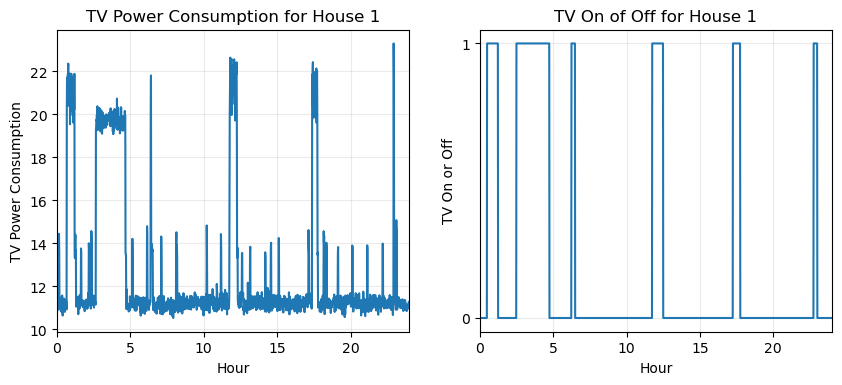

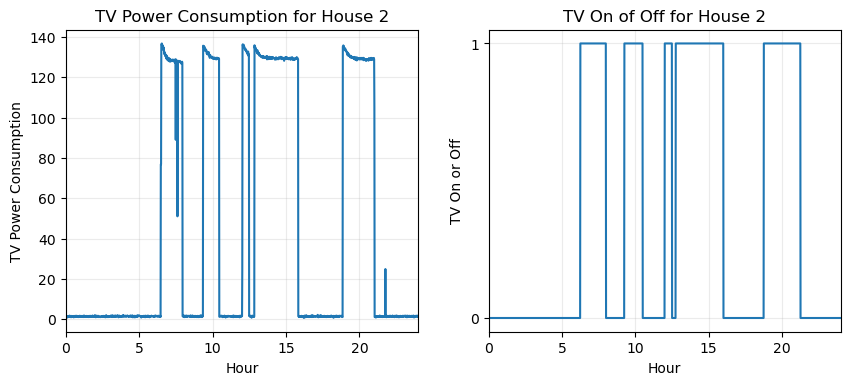

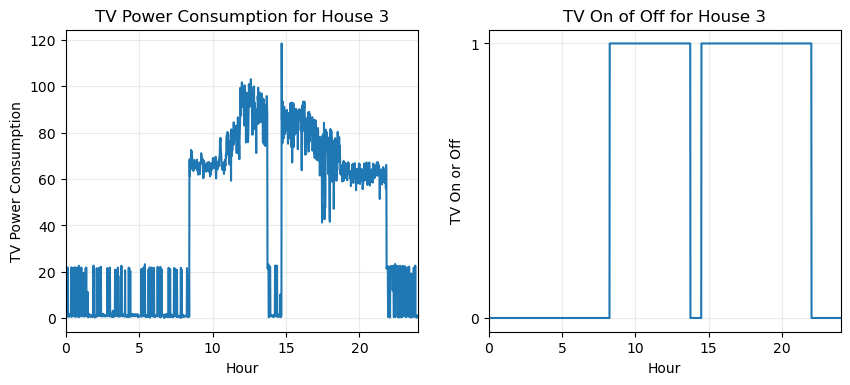

In [13]:
def plot_tv_on(house):
    global q3, processed
    df_raw = q3[q3['House']==house]
    df_processed = processed[processed['House']==house]
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4), dpi=100)
    ax[0].plot(df_raw['hour_float'], df_raw['TV'])
    ax[1].plot(df_processed['hour_float'], df_processed['on'])
    ax[0].set_ylabel('TV Power Consumption')
    ax[1].set_ylabel('TV On or Off')
    ax[0].set_title('TV Power Consumption for House {}'.format(house))
    ax[1].set_title('TV On of Off for House {}'.format(house))
    ax[1].set_yticks((0,1))
    for i in range(2):
        ax[i].set_xlim(0,24)
        ax[i].set_xlabel('Hour')
        ax[i].grid(alpha=0.25)

for house in processed['House'].unique():
    plot_tv_on(house)

## Final Thoughts for Task 1 

As visualised in the plots above, the method used for transforming raw data to achive the TV's `on` feature, does effective capture the times at which any TV would be ON, regardless of the fluctuations in the energy data, or the scale of the magnitude of energy consumed by each TV. However, this needs to be validated across a much wider range of data, as an extremely small sample of dataset was used to develop this methodology. Depending on the distribution of data, the `threshold_value` set to 0.5 might need to be altered, possibly even differently for each house, and outliers may require stripping.

# Task 2 

Thoughts on creating a binary classifier for predict TV On or Off:

+ Create transient features that checks for every quarterly hour, if there was a shift (+ or -) in `Agg` by about 75% of the `max_consumption` in either this or the previous hour quarter (for positive) or next hour quarter (for negative)
+ Avoid using house numbers or property specific data to prevent overfitting

In [14]:
processed

,House,Time,TV,Agg,hour,half_hour,quarter_hour,hour_float,TV_min,TV_max,max_consumption,half_consumption_power,on_threshold,on
0,1,0.0,11.463,26.205,0,0,0,0.000000,10.533,23.303,12.770,6.3850,16.9180,0
1,1,1.0,11.702,25.771,0,0,0,0.016667,10.533,23.303,12.770,6.3850,16.9180,0
2,1,2.0,11.016,24.963,0,0,0,0.033333,10.533,23.303,12.770,6.3850,16.9180,0
3,1,3.0,11.054,96.582,0,0,0,0.050000,10.533,23.303,12.770,6.3850,16.9180,0
4,1,4.0,11.123,100.034,0,0,0,0.066667,10.533,23.303,12.770,6.3850,16.9180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,3,1435.0,0.881,34.535,23,47,95,23.916667,0.125,118.392,118.267,59.1335,59.2585,0
4316,3,1436.0,0.768,34.501,23,47,95,23.933333,0.125,118.392,118.267,59.1335,59.2585,0
4317,3,1437.0,0.558,33.613,23,47,95,23.950000,0.125,118.392,118.267,59.1335,59.2585,0
4318,3,1438.0,1.081,34.107,23,47,95,23.966667,0.125,118.392,118.267,59.1335,59.2585,0


In [15]:
processed.corrwith(processed['on'])

House                     0.289875
Time                      0.144930
TV                        0.784007
Agg                       0.063164
hour                      0.144020
half_hour                 0.144444
quarter_hour              0.144938
hour_float                0.144930
TV_min                   -0.263401
TV_max                    0.235760
max_consumption           0.238538
half_consumption_power    0.238538
on_threshold              0.232314
on                        1.000000
dtype: float64

**Using difference between Agg to identify anctivities**

Attempting to see if using the Agg difference between consecutive timestamps as an indicator of TV being switched on or off, using `max_consumption` as a reference to detect the on or off.

In [16]:
dfs_to_agg = []

for house in processed.House.unique():
    house_df = processed[processed['House']==house].copy()
    house_df['Agg_diff'] = house_df['Agg'].diff()
    dfs_to_agg.append(house_df)
    
temp_df = pd.concat(dfs_to_agg)

In [17]:
temp_df[['House', 'Time', 'Agg_diff']].head()

,House,Time,Agg_diff
0,1,0.0,NaN
1,1,1.0,-0.434
2,1,2.0,-0.808
3,1,3.0,71.619
4,1,4.0,3.452


In [18]:
processed_with_diff = pd.merge(processed, temp_df[['House', 'Time', 'Agg_diff']], on=['House', 'Time'])

In [19]:
processed_with_diff

,House,Time,TV,Agg,hour,half_hour,quarter_hour,hour_float,TV_min,TV_max,max_consumption,half_consumption_power,on_threshold,on,Agg_diff
0,1,0.0,11.463,26.205,0,0,0,0.000000,10.533,23.303,12.770,6.3850,16.9180,0,NaN
1,1,1.0,11.702,25.771,0,0,0,0.016667,10.533,23.303,12.770,6.3850,16.9180,0,-0.434
2,1,2.0,11.016,24.963,0,0,0,0.033333,10.533,23.303,12.770,6.3850,16.9180,0,-0.808
3,1,3.0,11.054,96.582,0,0,0,0.050000,10.533,23.303,12.770,6.3850,16.9180,0,71.619
4,1,4.0,11.123,100.034,0,0,0,0.066667,10.533,23.303,12.770,6.3850,16.9180,0,3.452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,3,1435.0,0.881,34.535,23,47,95,23.916667,0.125,118.392,118.267,59.1335,59.2585,0,3.213
4316,3,1436.0,0.768,34.501,23,47,95,23.933333,0.125,118.392,118.267,59.1335,59.2585,0,-0.034
4317,3,1437.0,0.558,33.613,23,47,95,23.950000,0.125,118.392,118.267,59.1335,59.2585,0,-0.888
4318,3,1438.0,1.081,34.107,23,47,95,23.966667,0.125,118.392,118.267,59.1335,59.2585,0,0.494


The function below `tv_on` detects potentially if a TV could be switched on or off based on the increase or decrease in `Agg` feature by approximately the power consumed by TV at each home. The function outputs a 1 if it detects increase in `Agg`, -1 if it detects decrease in `Agg`, else a 0.

In [20]:
def tv_on(data, min_threshold, max_threshold):
    max_consumption, agg_diff = data[0], data[1]
    if agg_diff>max_consumption*0.5 and agg_diff<=max_consumption*max_threshold:
        return 1
    elif agg_diff*(-1)>=max_consumption*0.5 and agg_diff*(-1)<=max_consumption*max_threshold:
        return -1
    else:
        return 0

In [21]:
processed_with_diff['switched_on_tv'] = processed_with_diff[['max_consumption', 'Agg_diff']].apply(tv_on, axis=1, min_threshold=0.5, max_threshold=1.2)

In [22]:
processed_with_diff.sample(5)

,House,Time,TV,Agg,hour,half_hour,quarter_hour,hour_float,TV_min,TV_max,max_consumption,half_consumption_power,on_threshold,on,Agg_diff,switched_on_tv
3169,3,289.0,1.302,65.475,4,9,19,4.816667,0.125,118.392,118.267,59.1335,59.2585,0,-27.729,0
1138,1,1138.0,10.860,24.607,18,37,75,18.966667,10.533,23.303,12.770,6.3850,16.9180,0,-0.637,0
1889,2,449.0,89.004,90.476,7,14,29,7.483333,0.566,136.806,136.240,68.1200,68.6860,1,-129.773,-1
2090,2,650.0,1.249,100.393,10,21,43,10.833333,0.566,136.806,136.240,68.1200,68.6860,0,-2.298,0
1950,2,510.0,1.884,3.300,8,17,34,8.500000,0.566,136.806,136.240,68.1200,68.6860,0,0.213,0


In [23]:
processed_with_diff.to_csv('processed_with_diff.csv', index=False)

## Visualising extracted ON/OFF from `Agg`

The plots below illustrate the signals detected for ON/OFF based on the methodology discussed in the section above. The green dashed lines indicate a potential switch ON activity, whilst the red dashed line indicate a potential switched OFF activity for the televison.

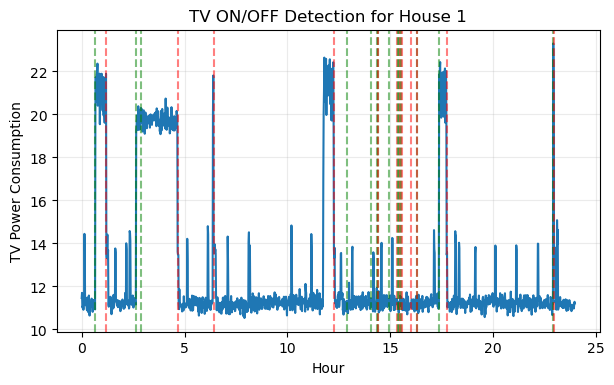

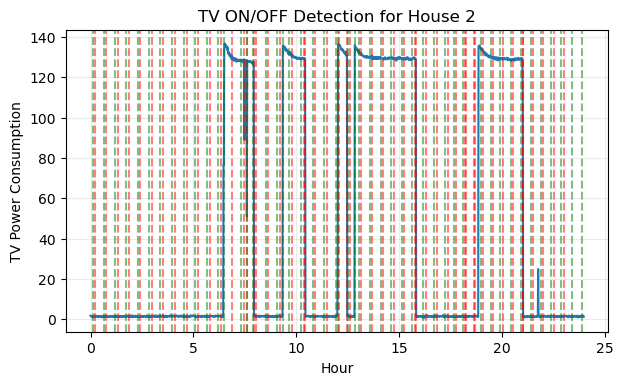

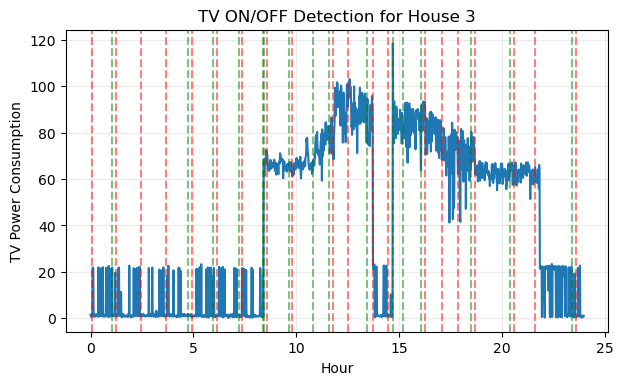

In [24]:
for house in processed_with_diff.House.unique():
    house_df = processed_with_diff[processed_with_diff['House']==house]
    house_df['TV_max']
    plt.figure(figsize=(7,4), dpi=100)
    plt.plot(house_df['hour_float'], house_df['TV'])
    plt.xlabel('Hour'); plt.ylabel('TV Power Consumption')
    plt.title('TV ON/OFF Detection for House {}'.format(house))
    plt.grid(alpha=0.25)
    temp_df = house_df[house_df['switched_on_tv']!=0][['hour_float', 'switched_on_tv']]
    for i, row in temp_df.iterrows():
        hour_float = row['hour_float']
        on_off = row['switched_on_tv']
        plt.axvline(hour_float, c='g' if on_off==1 else 'r', alpha=0.5, linestyle='--')

### Discussion 

+ The TV detection based on purely the `Agg`, using the `max_consumption` along with a wide threshold between 50% to 120%, to detect if the TV is ON, seems to detect most of the ON/OFF activities for House 1. However, it detects a lot of irrelevant signals, that could be created by other equipment, or could be just noise. 
+ Adjusting this threshold might product better results, but could be really tricky for a wide range of scenarios with different TVs and other household electricity usage patterns.

## Training a binary classifier 

The following code trains a binary classifier using the XGBoost algorithm, with conservative hyperparameters to better regularize the model. 

In [25]:
from xgboost import XGBClassifier

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
input_features = [
    'Time',
    'hour_float',
    'half_hour',
    'quarter_hour',
    'max_consumption',
    'Agg'
]

In [28]:
X, y = processed_with_diff[input_features], processed_with_diff['on']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101, stratify=y)

In [30]:
y_train.value_counts()

0    2025
1    1215
Name: on, dtype: int64

In [31]:
y_test.value_counts()

0    675
1    405
Name: on, dtype: int64

In [32]:
xgb_classifier = XGBClassifier(
    max_depth=4,
    booster='gbtree',
    reg_lambda=100,
    subsample=0.5,
    n_estimators=20,
    random_state=101
)

In [33]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=101, reg_alpha=0,
              reg_lambda=100, scale_pos_weight=1, subsample=0.5,
              tree_method=None, validate_parameters=False, verbosity=None)

In [34]:
predictions = xgb_classifier.predict(X_test)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       675
           1       0.92      0.83      0.87       405

    accuracy                           0.91      1080
   macro avg       0.91      0.89      0.90      1080
weighted avg       0.91      0.91      0.91      1080



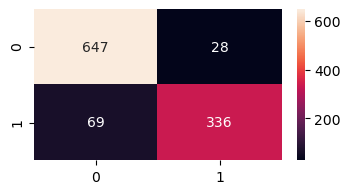

In [37]:
plt.figure(figsize=(4,2), dpi=100)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='.0f')

In [38]:
feature_imp = pd.DataFrame(
    xgb_classifier.feature_importances_, 
    index=input_features, 
    columns=['Imp']
).sort_values('Imp', ascending=False)

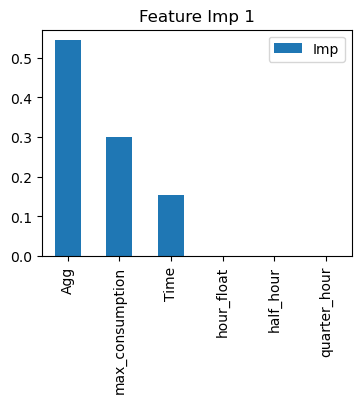

In [39]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=100)
feature_imp.plot(kind='bar', ax=ax, title='Feature Imp 1')

## Discussion and Recommendation

Descpite have a high accuracy this is not a reliable model. The following are the key conclusions and recommendations that can be made to train a classifier to detect a TV on or off:

+ The model achives a high accuracy despite rigorous regularization, clearly indicating overfitting. However this is expected, as the data is very niche / specific to just 3 households, and a very small sample. Apart from a tree based algorithm, any linear classifier would not produce acceptable results as the `Agg` field or the timestamps do not hold a linear relationship with TV being on or off, as they are widely affected by other electricity usage, i.e. washing machine, laptops, etc... whose scale could be significantly larger than that consumed by TV
+ Adjusting thresholds to detect TV activities, could improve the detection features like the one engineered in the previous section `switched_on_tv`
+ This problem is better suited for a time-series forecasting solution where the dataset in the following manner:
    + Normalised and organised in chunks of time-series dynamic features for `Agg`, and other time-based features, and use them in RNN's (LSTM possibly) as timeseries input
    + Use additional customer specific features, to cluster customers that share similar usage patterns, and then feed the static information separately via a secondary input channel which later concatenates to the timeseries data at the upper layers of the neural network
    + Use TV's ON/OFF data as the target timeseries feature for the network